In [1]:
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from scoring_tables import make_table

2024-03-06 10:33:24.496935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:33:24.523600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 10:33:24.523624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 10:33:24.524401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 10:33:24.528638: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:33:24.529097: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
neighbourhood_size = 11
parameter_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']
ignore = ['229', '285', '323']
train_folds = [1, 2]
train_data = get_normalized_tensor(neighbourhood_size, parameter_names, train_folds, ignore)

X_train = train_data['X']
y_train = train_data['y']
variances_train = train_data['variances']
mean_train = train_data['mean']
std_train = train_data['std']


print(X_train.shape)

(15733, 5)


In [3]:
test_fold = 3

X_test, y_test, variances_test = get_tensors(neighbourhood_size, parameter_names, test_fold, ignore)
X_test = (X_test - mean_train) / std_train

print(X_test.shape)

(7780, 5)


In [6]:
setup = {}

setup["num_features"] = len(parameter_names)
setup["feature_mean"] = mean_train
setup["feature_std"] = std_train
setup["features"] = parameter_names
setup["neighbourhood_size"] = neighbourhood_size

Possible settings for EMOS class:

loss:

    loss_CRPS_sample
    loss_log_likelihood
    loss_Brier_score 
    loss_twCRPS_sample

in case sample is used loss: sample

chaining_functions

    chain_function_indicator 
        includes:
        
         threshold
    chain_function_normal_cdf
        includes: 
        
        chain_function_mean
         chain_function_std

optimizer:

    Adam
    SGD

learning_rate:
    -Positive real valued number

forecast_distribution:

    distr_trunc_normal
    distr_log_normal
    distr_gev(2/3)

    distr_mixture (which contains two of the above distributions)
    distr_mixture_linear

they must contain distribution_1/distribution_2

    


In [7]:
models_crps = {}
setup1 = setup

setup1["loss"] = "loss_CRPS_sample"
setup1["samples"] = 100
setup1["optimizer"] = "Adam"
setup1["learning_rate"] = 0.01
setup1["forecast_distribution"] = "distr_trunc_normal"

crps_tn = EMOS(setup1)

setup1["forecast_distribution"] = "distr_log_normal"

crps_ln = EMOS(setup1)

setup1["forecast_distribution"] = "distr_gev"
setup1["samples"] = 300

crps_gev = EMOS(setup1)

setup1["forecast_distribution"] = "distr_frechet"

crps_frechet = EMOS(setup1)





models_crps["crps_tn"] = crps_tn
models_crps["crps_ln"] = crps_ln
models_crps["crps_gev"] = crps_gev
models_crps["crps_frechet"] = crps_frechet


print(len(models_crps))

Using default parameters for truncated normal distribution
Using default parameters for Log Normal distribution
Using default parameters for Generalized Extreme Value distribution
Using default parameters for Frechet distribution
4


In [9]:
epochs = 600

for model in models_crps:
    models_crps[model].fit(X_train, y_train, variances_train, epochs, printing=False)
    print("Model: ", models_crps[model])

Final loss:  0.90661025
Model:  EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.40002263]
  b_tn: [ 0.9647988  -0.0264985  -0.14570539  0.03277409  0.01300835]
  c_tn: [1.5207014]
  d_tn: [1.0384889]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582

Final loss:  1.0506324
Model:  EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_log_normal
Parameters:
  a_ln: [0.8468263]
  b_ln: [ 0.13367817 -0.08109702 -0.03524413 -0.02242074  0.07428258]
  c_ln: [0.12324135]
  d_ln: [-0.000918]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582

Final loss:  0.9072674
Model:  EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 300)
Forecast distribution: 

KeyError: 'a_gev'

In [7]:
setup1["forecast_distribution"] = "distr_mixture"
setup1["distribution_1"] = "distr_trunc_normal"
setup1["distribution_2"] = "distr_log_normal"

mixture_trunc_log_crps = EMOS(setup1)
mixture_trunc_log_crps.set_parameters(models_crps["trunc_normal_crps"].get_parameters())
mixture_trunc_log_crps.set_parameters(models_crps["log_normal_crps"].get_parameters())

setup1["distribution_2"] = "distr_gev"
mixture_trunc_gev_crps = EMOS(setup1)

mixture_trunc_gev_crps.set_parameters(models_crps["trunc_normal_crps"].get_parameters())
mixture_trunc_gev_crps.set_parameters(models_crps["gev_crps"].get_parameters())

models_crps["mixture_trunc_log_crps"] = mixture_trunc_log_crps
models_crps["mixture_trunc_gev_crps"] = mixture_trunc_gev_crps




Using default parameters for truncated normal distribution
Using default parameters for Log Normal distribution
Parameter a_tn set to [0.39877644]
Parameter b_tn set to [ 0.96537703 -0.02143944 -0.14677921  0.03340424  0.00861133]
Parameter c_tn set to [1.5119647]
Parameter d_tn set to [1.0494062]
Parameter a_ln set to [0.84717226]
Parameter b_ln set to [ 0.13415903 -0.08256909 -0.03494003 -0.02212007  0.07403305]
Parameter c_ln set to [0.12252551]
Parameter d_ln set to [-0.00185185]
Using default parameters for truncated normal distribution
Using default parameters for Generalized Extreme Value distribution
Parameter a_tn set to [0.39877644]
Parameter b_tn set to [ 0.96537703 -0.02143944 -0.14677921  0.03340424  0.00861133]
Parameter c_tn set to [1.5119647]
Parameter d_tn set to [1.0494062]
Parameter a_gev set to [0.45506248]
Parameter b_gev set to [ 0.85179746 -0.06311508 -0.06636012 -0.00752052  0.05263763]
Parameter c_gev set to [0.7451227]
Parameter d_gev set to [ 0.14845866  0.01

In [8]:
models_crps["mixture_trunc_gev_crps"].fit(X_train, y_train, variances_train, epochs, printing=False)
print("Model: ", models_crps["mixture_trunc_gev_crps"])

models_crps["mixture_trunc_log_crps"].fit(X_train, y_train, variances_train, epochs, printing=False)
print("Model: ", models_crps["mixture_trunc_log_crps"])

Model:  EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 300)
Forecast distribution: distr_mixture
Distribution 1: distr_trunc_normal
Distribution 2: distr_gev
Mixture weight: [0.7461292]Parameters:
  weight: [0.7461292]
  a_tn: [0.17826913]
  b_tn: [ 0.9718878   0.03630939 -0.22908656  0.01684522  0.09398254]
  c_tn: [2.1452122]
  d_tn: [1.4145594]
  a_gev: [0.18985537]
  b_gev: [ 0.8615058  -0.02287646 -0.11507069 -0.00831719  0.093931  ]
  c_gev: [0.99556327]
  d_gev: [ 0.34962878 -0.50541764  0.35834497  0.27062848 -0.6795567 ]
  e_gev: [-0.18589401]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582

Model:  EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 300)
Forecast distribution: distr_mixture
Distribution 1: distr_trunc_normal
Distribution 2: distr_log_normal
Mixture weight: [0.6916055]Parameters:
  weight: [0.6916055]
  a_tn: [-1.0283713]
  b_t

In [9]:
base_model = models_crps.pop("trunc_normal_crps")
print(base_model)


EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.39877644]
  b_tn: [ 0.96537703 -0.02143944 -0.14677921  0.03340424  0.00861133]
  c_tn: [1.5119647]
  d_tn: [1.0494062]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



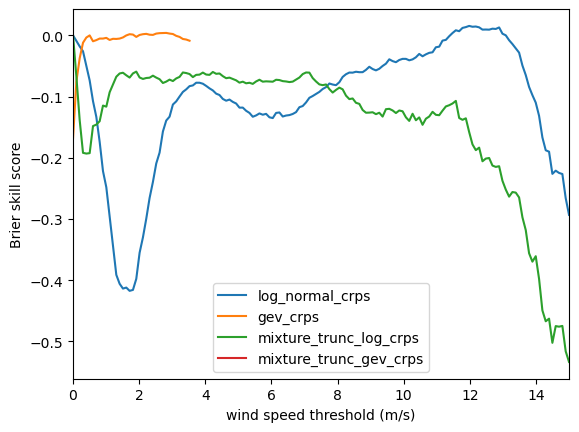

In [10]:
values = np.linspace(0, 15, 150)
brier_skill_plot(base_model, models_crps, X_test, y_test, variances_test, values)

In [15]:
t = [10, 11,12,13,14,15]
samples = 1000
models_crps['trunc_normal_crps'] = base_model

make_table(models_crps, X_test, y_test, variances_test, t, samples)

'+------------------------+----------+----------+-----------+-----------+-----------+-----------+-----------+\n| Model                  |     CRPS |   t = 10 |    t = 11 |    t = 12 |    t = 13 |    t = 14 |    t = 15 |\n+========================+==========+==========+===========+===========+===========+===========+===========+\n| log_normal_crps        | 1.03035  | 0.171275 | 0.131885  | 0.102391  | 0.0801989 | 0.06348   | 0.0505541 |\n+------------------------+----------+----------+-----------+-----------+-----------+-----------+-----------+\n| gev_crps               | 0.890981 | 0.132688 | 0.0938935 | 0.0636266 | 0.0415286 | 0.0256181 | 0.0154938 |\n+------------------------+----------+----------+-----------+-----------+-----------+-----------+-----------+\n| mixture_trunc_log_crps | 0.892852 | 0.13308  | 0.0948174 | 0.0641383 | 0.0425652 | 0.026238  | 0.0157605 |\n+------------------------+----------+----------+-----------+-----------+-----------+-----------+-----------+\n| mixture